In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from numpy import *
from IPython.html.widgets import *
from IPython.display import display
import matplotlib.pyplot as plt
from IPython.core.display import clear_output

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Gini coefficient

Gini coefficient is a measure of statistical dispersion.  For the Kaggle competition, the **normalized Gini coefficient** is used as a measure of comparing how much the *ordering* of the model prediction matches the actual output.  The magnitudes of the prediction do matter, but not in the same way they do in regular regressions.

The Gini coefficient is calculated as follows.  As an example, let's say we have the following `target` values and model `output` (predictions):

In [2]:
target=array([1,4,8,5])
output=array([1,8,4,5])

In the above example, the prediction `output` is not perfect, because we have the `4` and `8` switched.  Regardless, we first sort the `output` from the largest to the smallest and calculate the sort ordering:

In [3]:
sort_index=argsort(-output)  # Because we want to sort from largest to smallest
print(sort_index)

[1 3 2 0]


Next, we sort the target values using *this* sorting order.  Since the predicted order was incorrect, the target values are not going to be sorted by largest to the smallest.

In [4]:
sorted_target=target[sort_index]
print(sorted_target)

[4 5 8 1]


Then we look at the cumulative sum, and divide by the total sum to get the proportion of the cumulative sum.

In [5]:
cumsum_target=cumsum(sorted_target)
print(cumsum_target)
cumsum_target_ratio=cumsum_target / asarray(target.sum(), dtype=float)  # Convert to float type
print(cumsum_target_ratio)

[ 4  9 17 18]
[ 0.22222222  0.5         0.94444444  1.        ]


Let's plot `cumsum_target_ratio`:

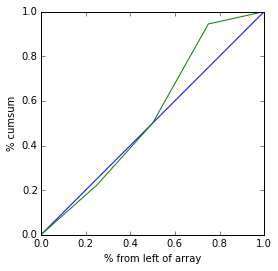

In [21]:
xs=linspace(0, 1, len(cumsum_target_ratio) + 1)
plt.plot(xs, c_[xs, r_[0, cumsum_target_ratio]])
plt.gca().set_aspect('equal')
plt.gca().set_xlabel(r'% from left of array')
plt.gca().set_ylabel(r'% cumsum')

`cumsum_target_ratio` was plotted in green, whereas The line for $y = x$ was also plotted in blue.  This line represents the **random model prediction**.  If we had a large array of numbers, sorted it *randomly* and looked at the cumulative sum from the left, we would expect the cumulative sum to be about 10% of the total when we look at the number 10% from the left.  In general, we would expect $x$ % of the cumulative sum total for the array element that is $x$ % from the left of the array.

Finally, the **Gini coefficient** is determined to be the "area" between the green and the blue lines: green values minus the blue line values.  (This can also be negative in some places, as we see above; hence the quotation marks.)

In [22]:
gini_coeff=(r_[0, cumsum_target_ratio] - xs).sum()
print(gini_coeff)

0.166666666667


For convenience, we collect the above in a function.

In [33]:
def gini_coeff(target, output):
    sort_index=argsort(-output)  # Because we want to sort from largest to smallest
    sorted_target=target[sort_index]
    cumsum_target=cumsum(sorted_target)
    cumsum_target_ratio=cumsum_target / asarray(target.sum(), dtype=float)  # Convert to float type
    xs = linspace(0, 1, len(cumsum_target_ratio) + 1)
    return (r_[0, cumsum_target_ratio] - xs).sum()

print(gini_coeff(target, output))

0.166666666667


Note that we can also calculate the Gini coefficient of two same vectors.  In this case, it returns the maximum value that can be achievable by any sorting of the same set of numbers:

In [24]:
print(gini_coeff(target, target))

0.611111111111


Finally, the **normalized Gini coefficient** is defined as the ratio of Gini coefficient between the target and the prediction with respect to the maximum value achievable from the target values themselves:

In [25]:
def normalized_gini(target, output):
    return gini_coeff(target, output) / gini_coeff(target, target)

print(normalized_gini(target, output))

0.272727272727


The **normalized Gini coefficient** has the maximum of 1, when the ordering is correct.  

In [27]:
print(normalized_gini(target, target))

1.0


The model prediction is considered better the closer it is to 1.  It appears that this number can become negative, though, if the prediction is very bad (the opposite ordering, for example):

In [29]:
target=array([1,4,8,5])
output2=array([5,8,4,1])

print(normalized_gini(target, output2))

-0.454545454545


This measure is insensitve to the magnitudes:

In [39]:
target=array([1,4,8,5])
output3=array([10,80,40,50])
output4=array([0,3,1,2])

print(normalized_gini(target, output3))
print(normalized_gini(target, output4))

0.272727272727
0.272727272727


However, because we are sorting from the largest to the smallest number (and looking at the ratio of the largest to the total), it is **more important to predict the samples with large numbers**.

To wit, here're two sets of predictions:

In [53]:
target_large=array([1,2,1,2,1,2,1,2,1,2,9])
output_small=array([2,1,2,1,2,1,2,1,2,1,8])  # All 1, 2 s are wrong, but got the largest number right
output_large=array([1,2,1,2,1,2,1,2,1,6,2])  # Got most 1, 2 s right, but missed the largest number

print('output_small RMSE: %f' % sqrt((target_large-output_small)**2).mean())
print('output_large RMSE: %f' % sqrt((target_large-output_large)**2).mean())

print('output_small normalized Gini: %f' % normalized_gini(target_large, output_small))
print('output_large normalized Gini: %f' % normalized_gini(target_large, output_large))

output_small RMSE: 1.000000
output_large RMSE: 1.000000
output_small NGini: 0.500000
output_large NGini: 0.300000


There's a much larger penality to getting the largest quantity wrong for the normalized Gini (even though the root-mean squared errors are equal in both cases).